## Дистилляция - база


[Awesome Knowledge Distillation](https://github.com/dkozlov/awesome-knowledge-distillation)

### Общая идея

Дистилляция - процесс, при котором простая модель (ученик) пытается научиться "подражать"  своими ответами некоторой большой умной модели (учителю)

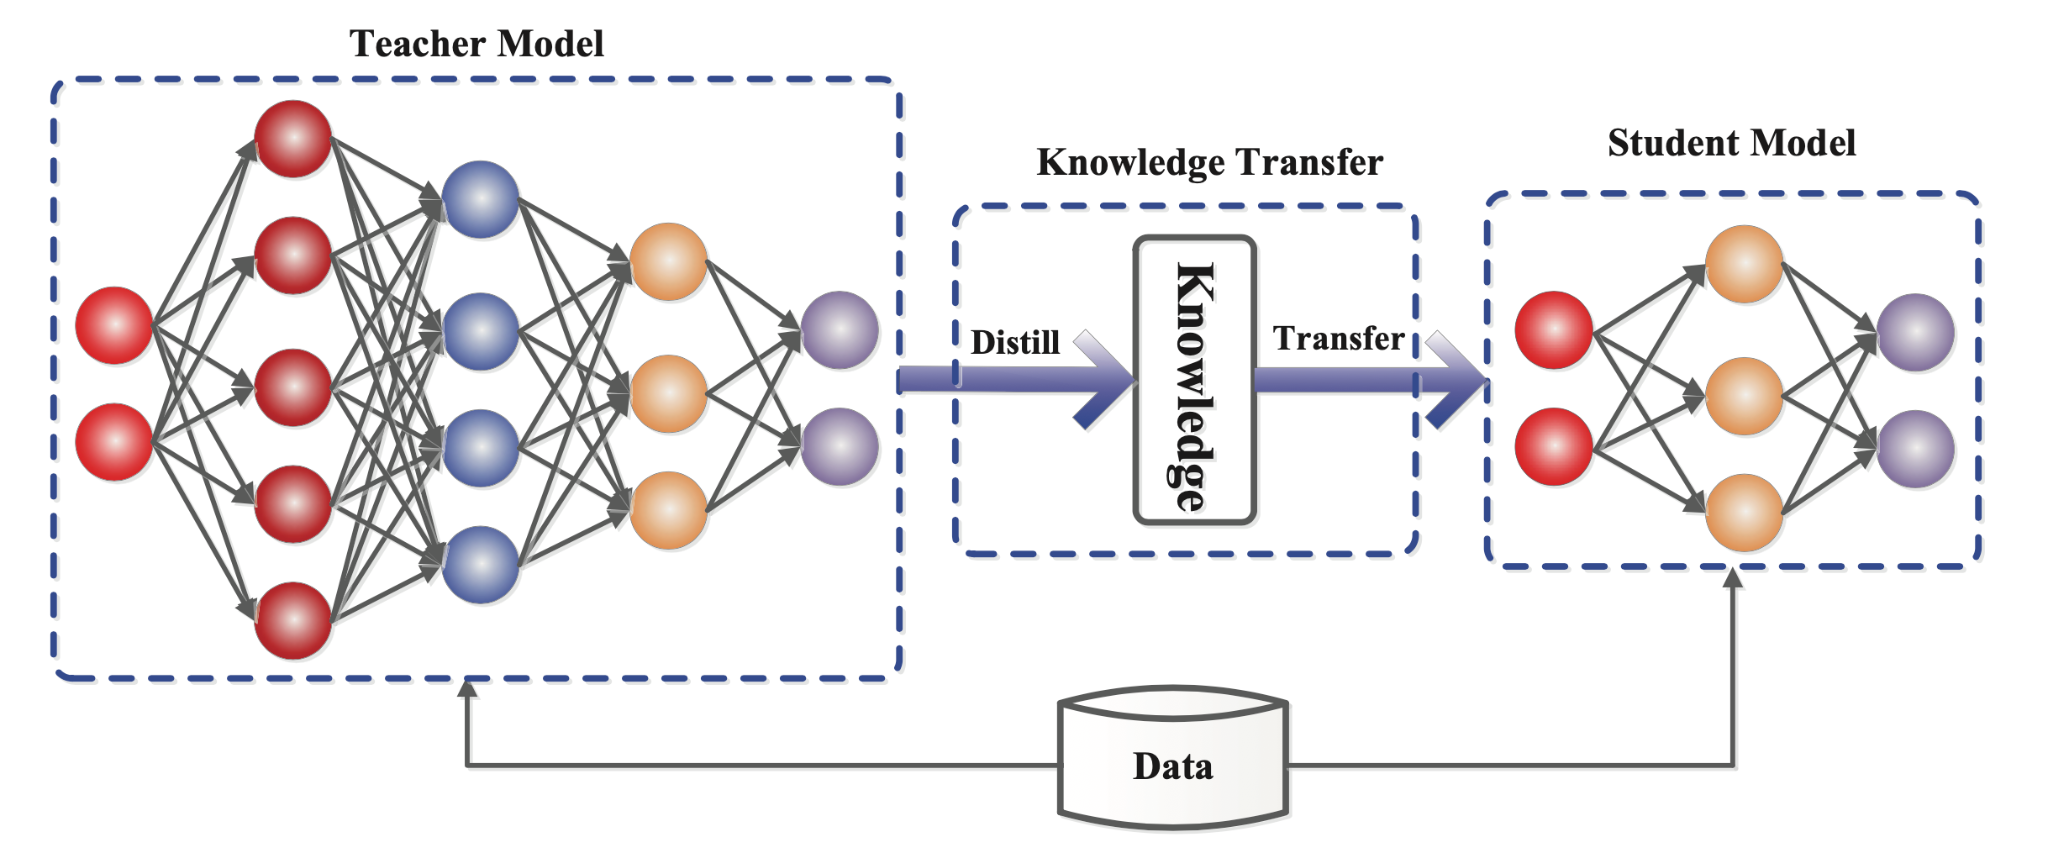

Схематично процесс можно представить так


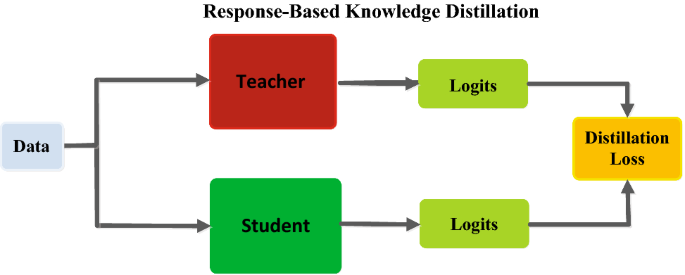

Или так

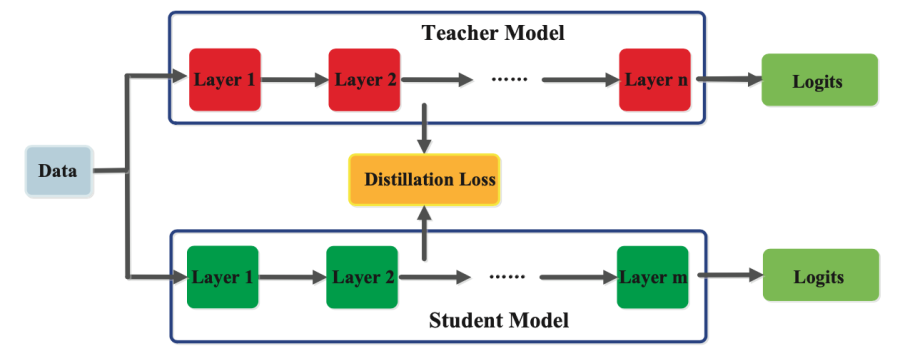

### Функции потерь

Для начала возьмем функцию потерь для выучивания ответов модели-учителя

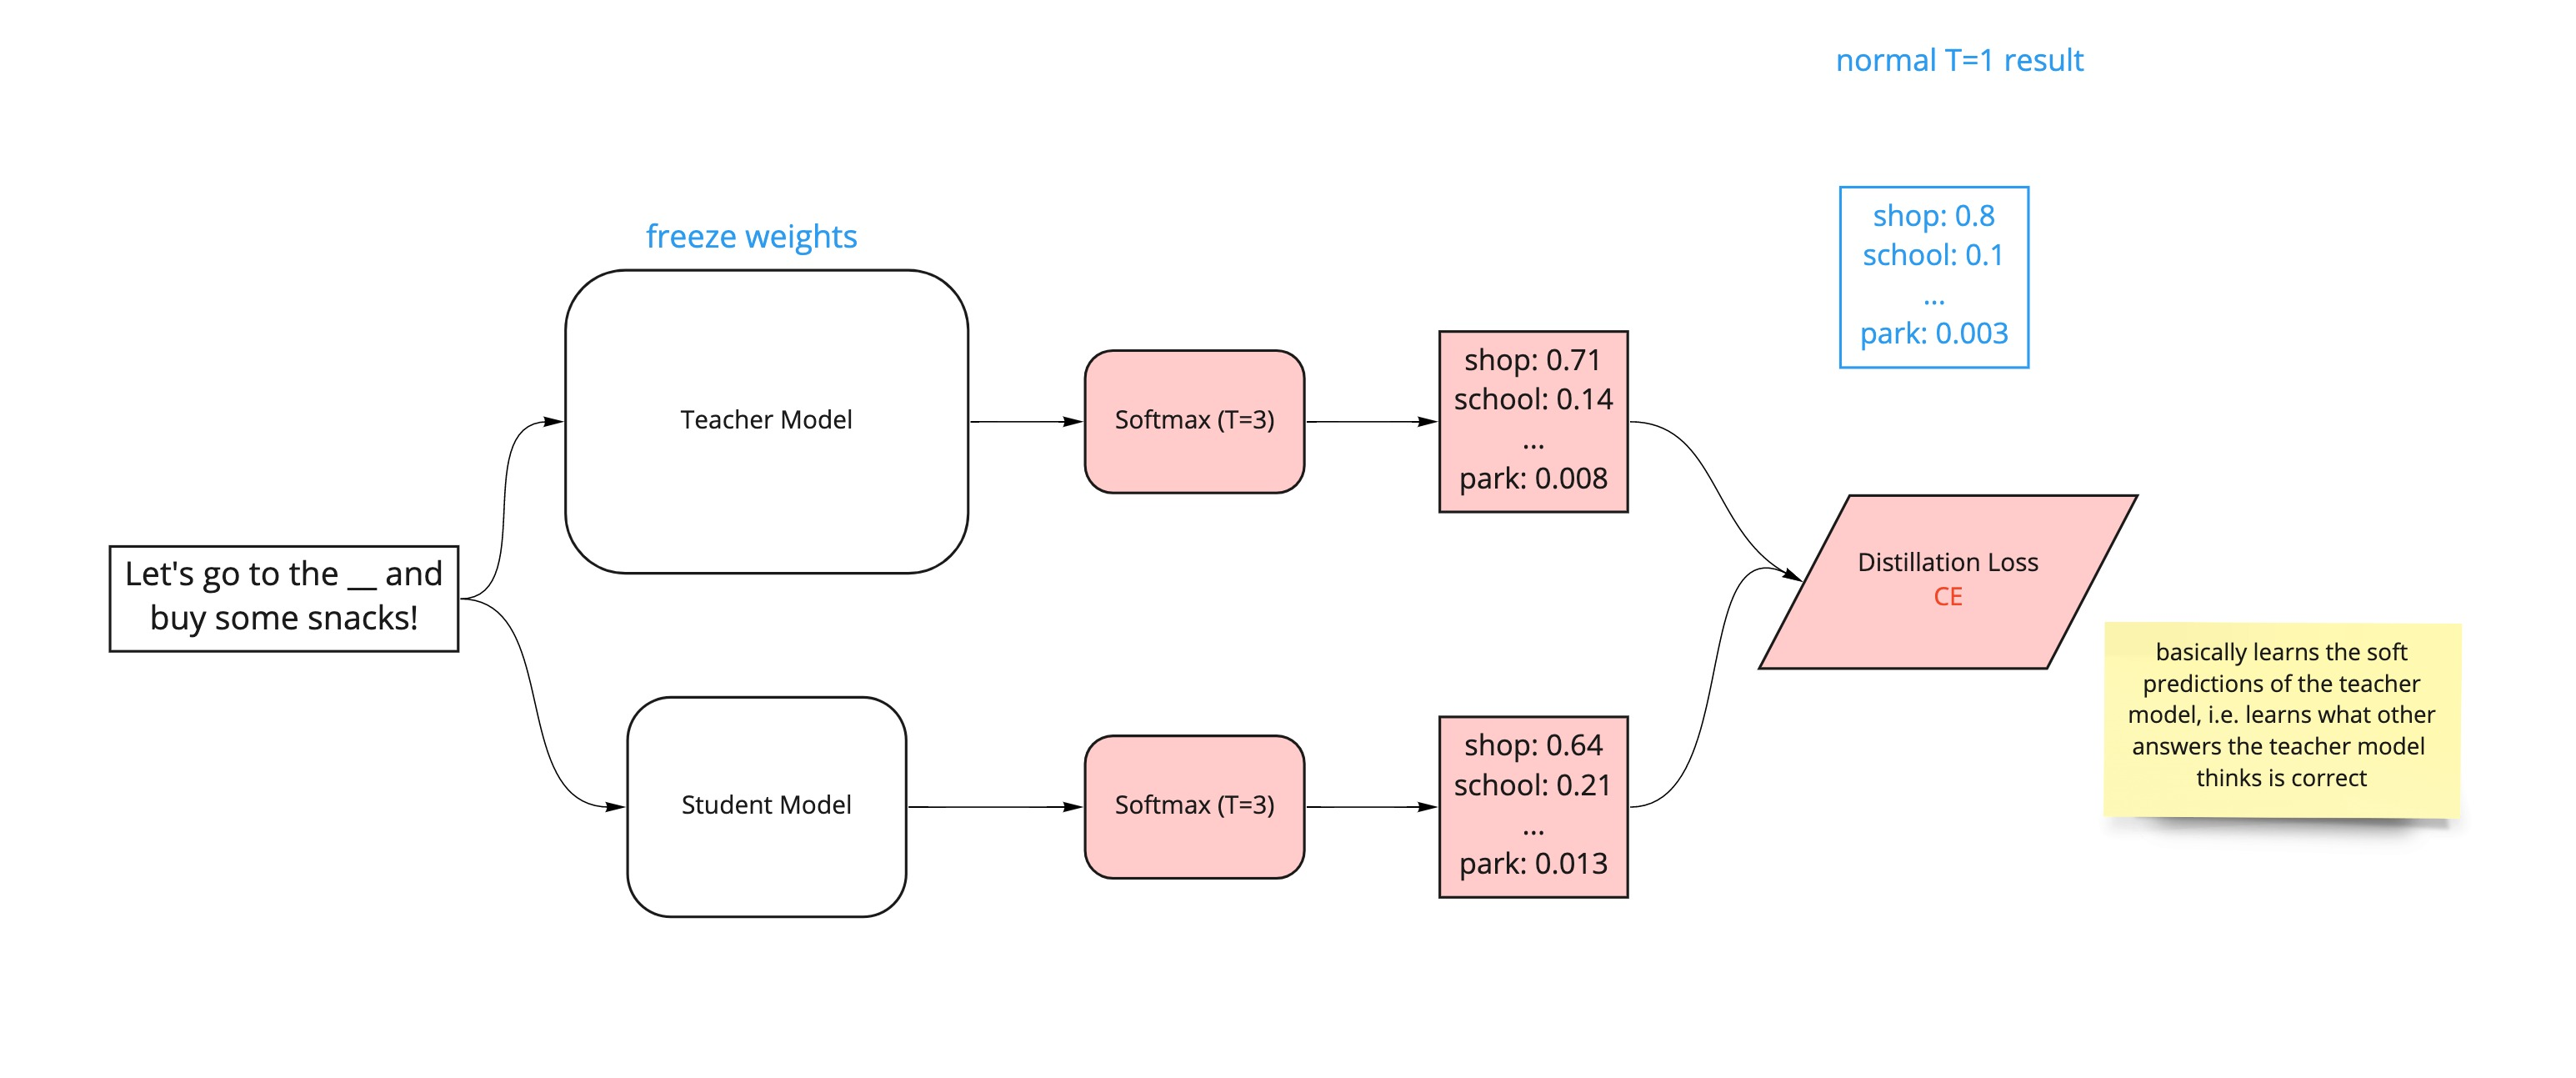

Было бы круто еще контролировать, что мы точно все еще учимся решать задачу, а не переобучаемся под большую модель: добавим еще один loss - для выучивания реальных данных

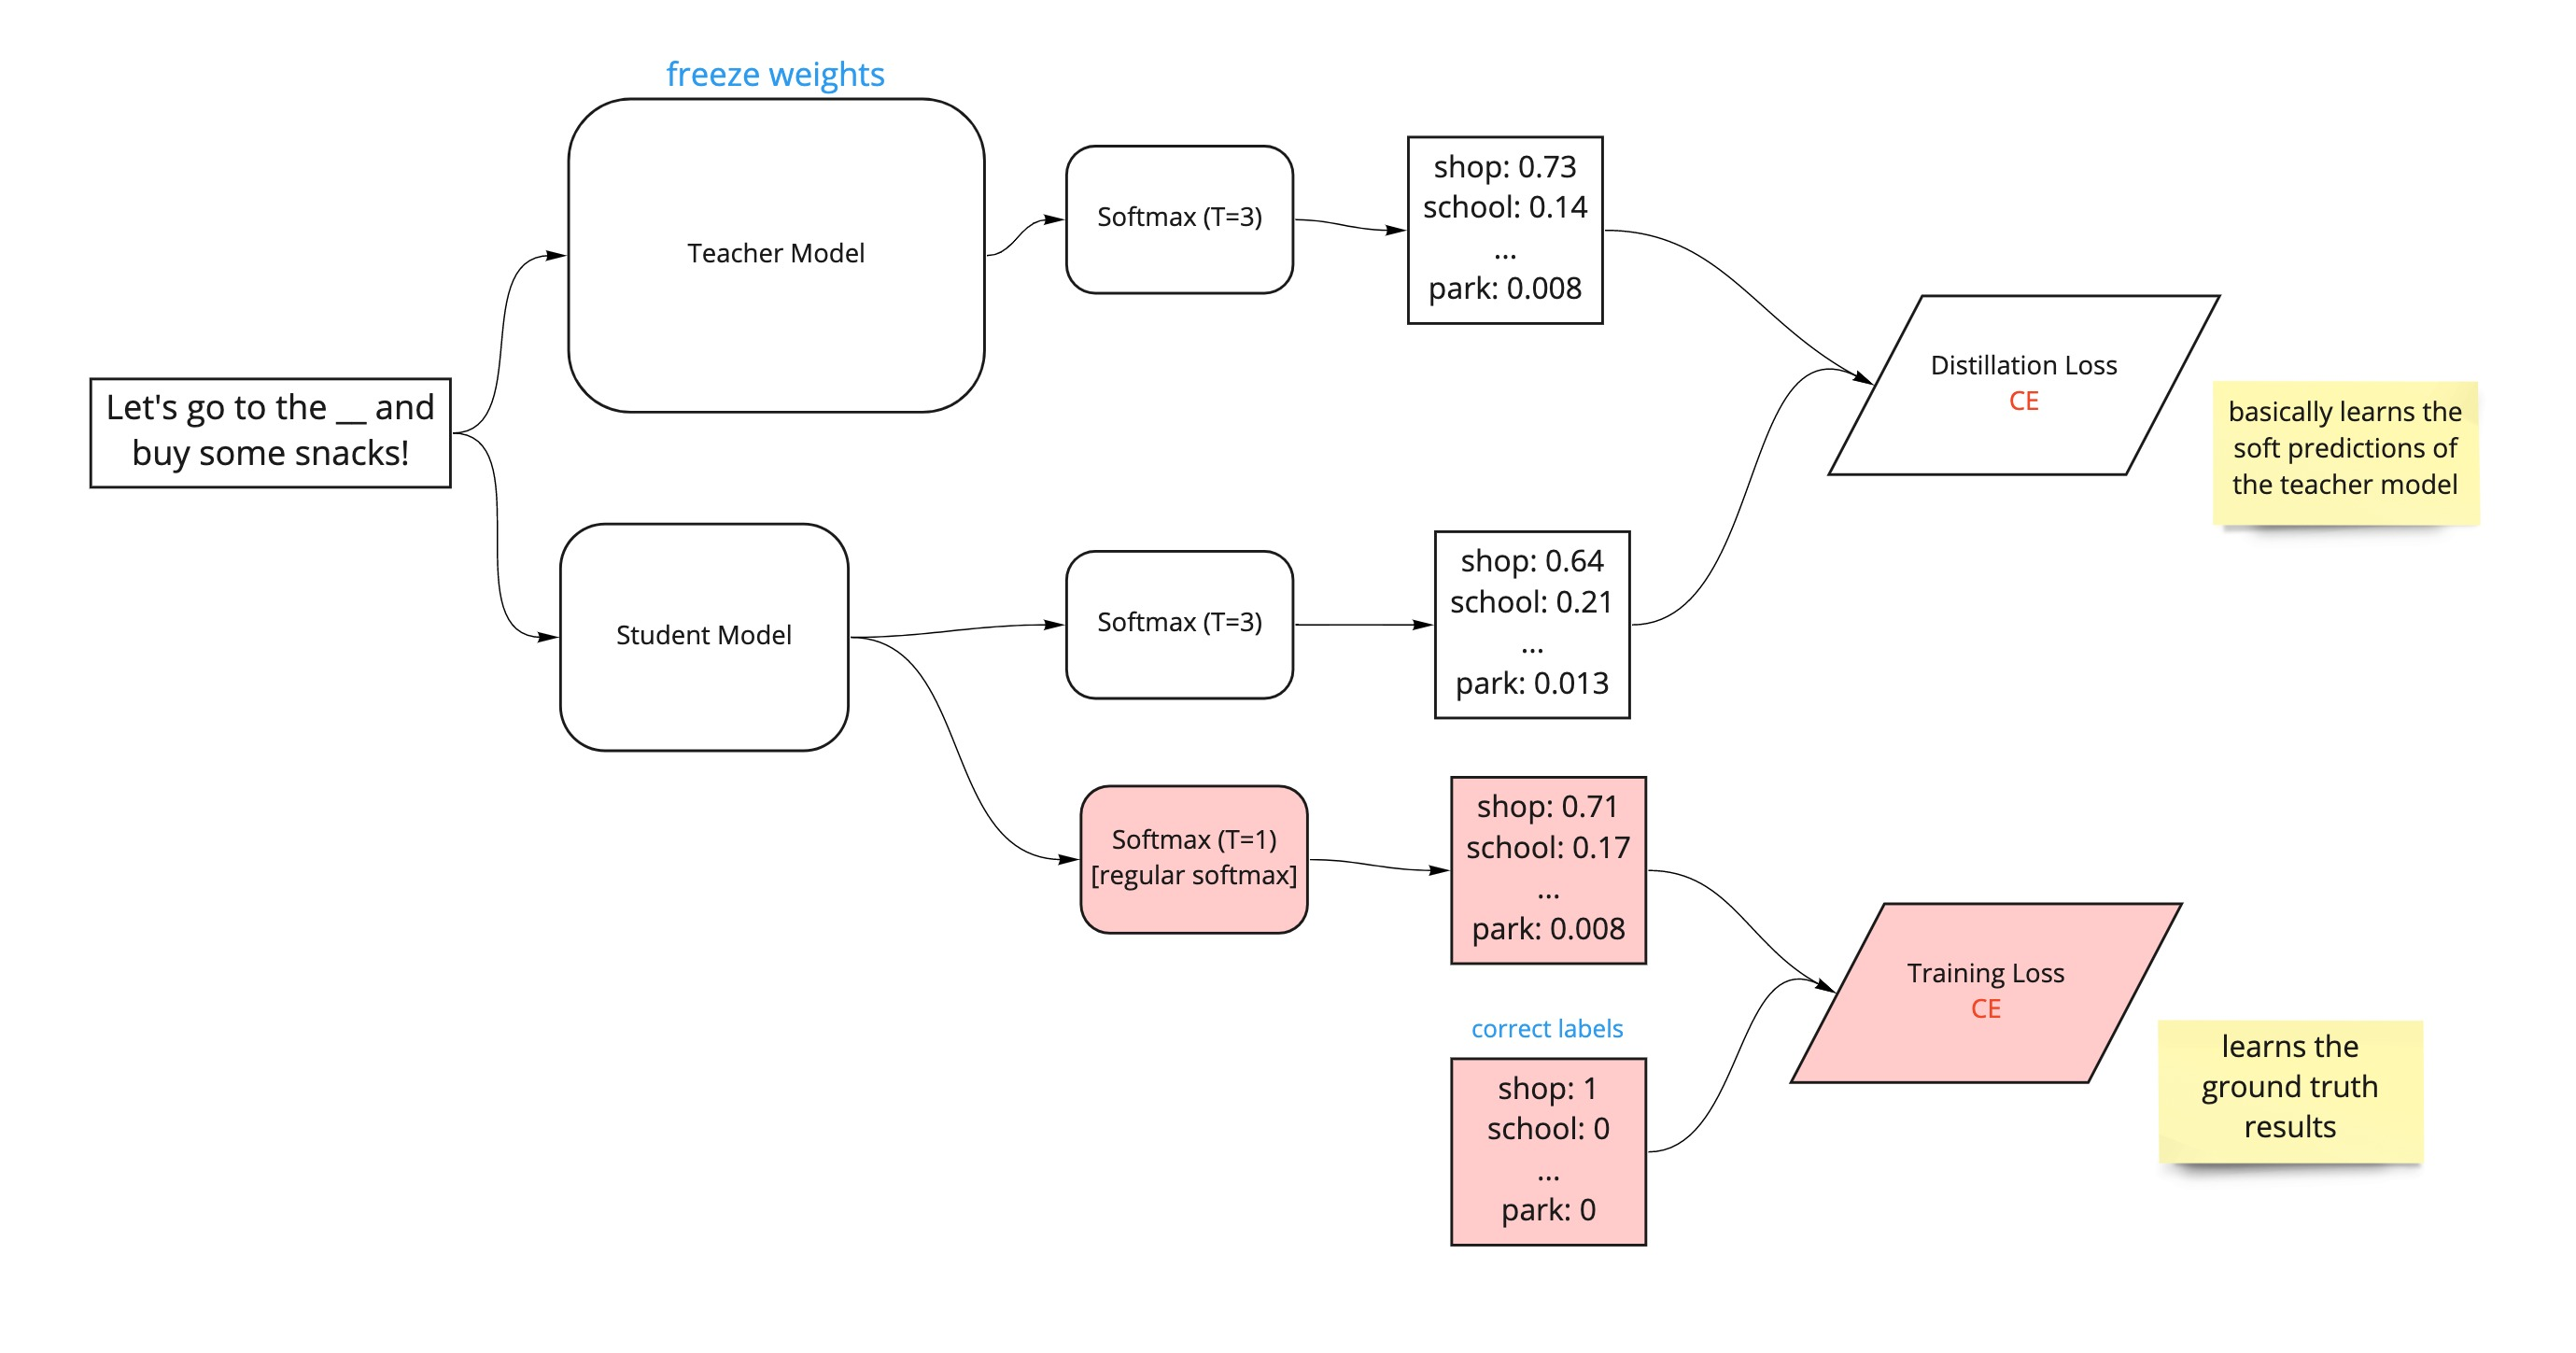

Можно еще немного пожестить и добавить ко всему этому косинусный лосс, чтобы заставить ученика подгонять свои эмбеддинги под учителя

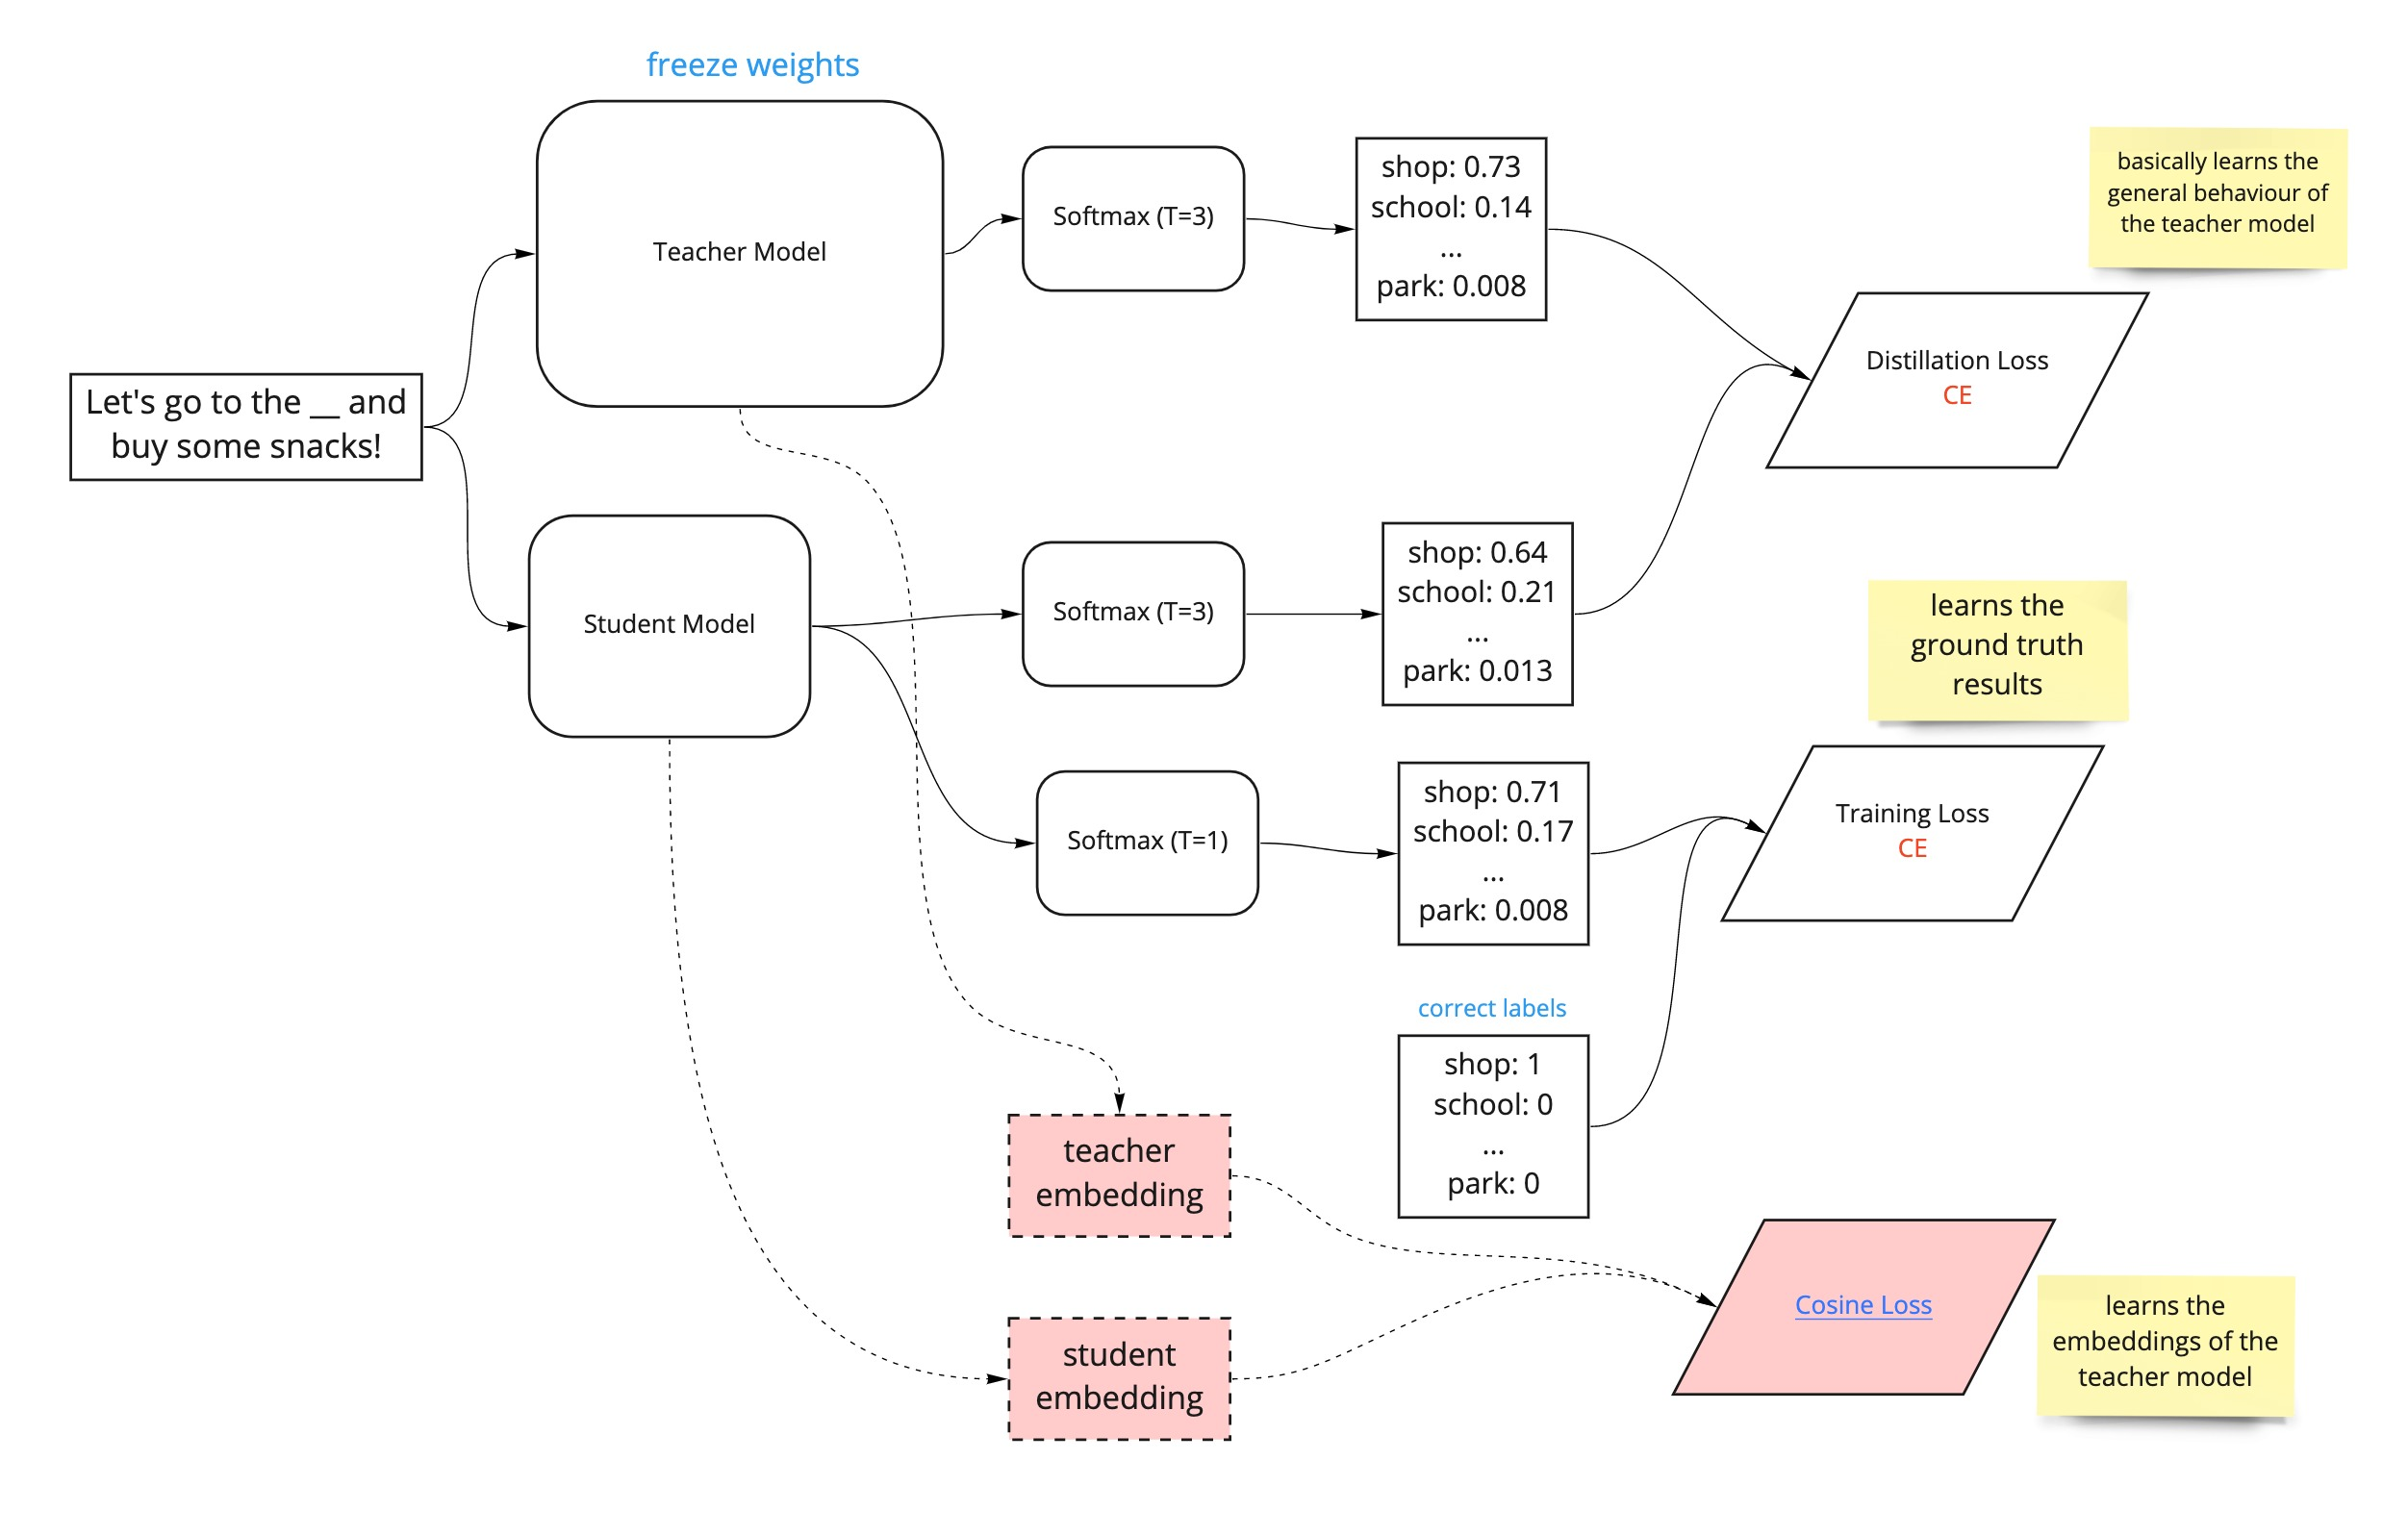

### DistilBert

Использует почти ту же архитектуру, что и BERT, но только с 6 блоками энкодера (в base BERT их 12). Эти блоки инициализируются простым взятием одного из каждых двух предобученных блоков энкодеров BERT.

В отличие от BERT, DistilBERT предобучается только через моделирование языка по маске (оставили MLM и убрали Next Sentence Prediction). DistilBERT обучается с использованием тройного лосса:

- Тот же лосс языковой модели, что и в BERT;

- Лосс дистилляции измеряет сходство выходов между DistilBERT и BERT;

- Лосс косинусового расстояния измеряет, насколько похожи скрытые состояния DistilBERT и BERT.

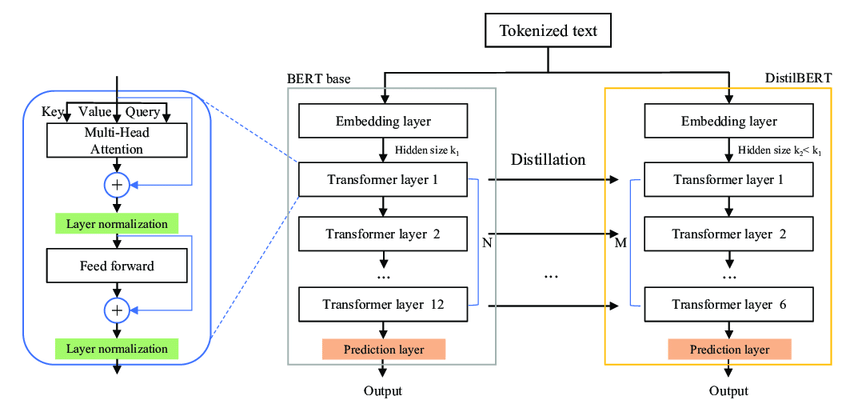

[DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

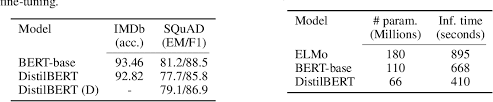

### Distillation task-types

[TinyBERT: Distilling BERT for Natural Language Understanding](https://arxiv.org/pdf/1909.10351.pdf)

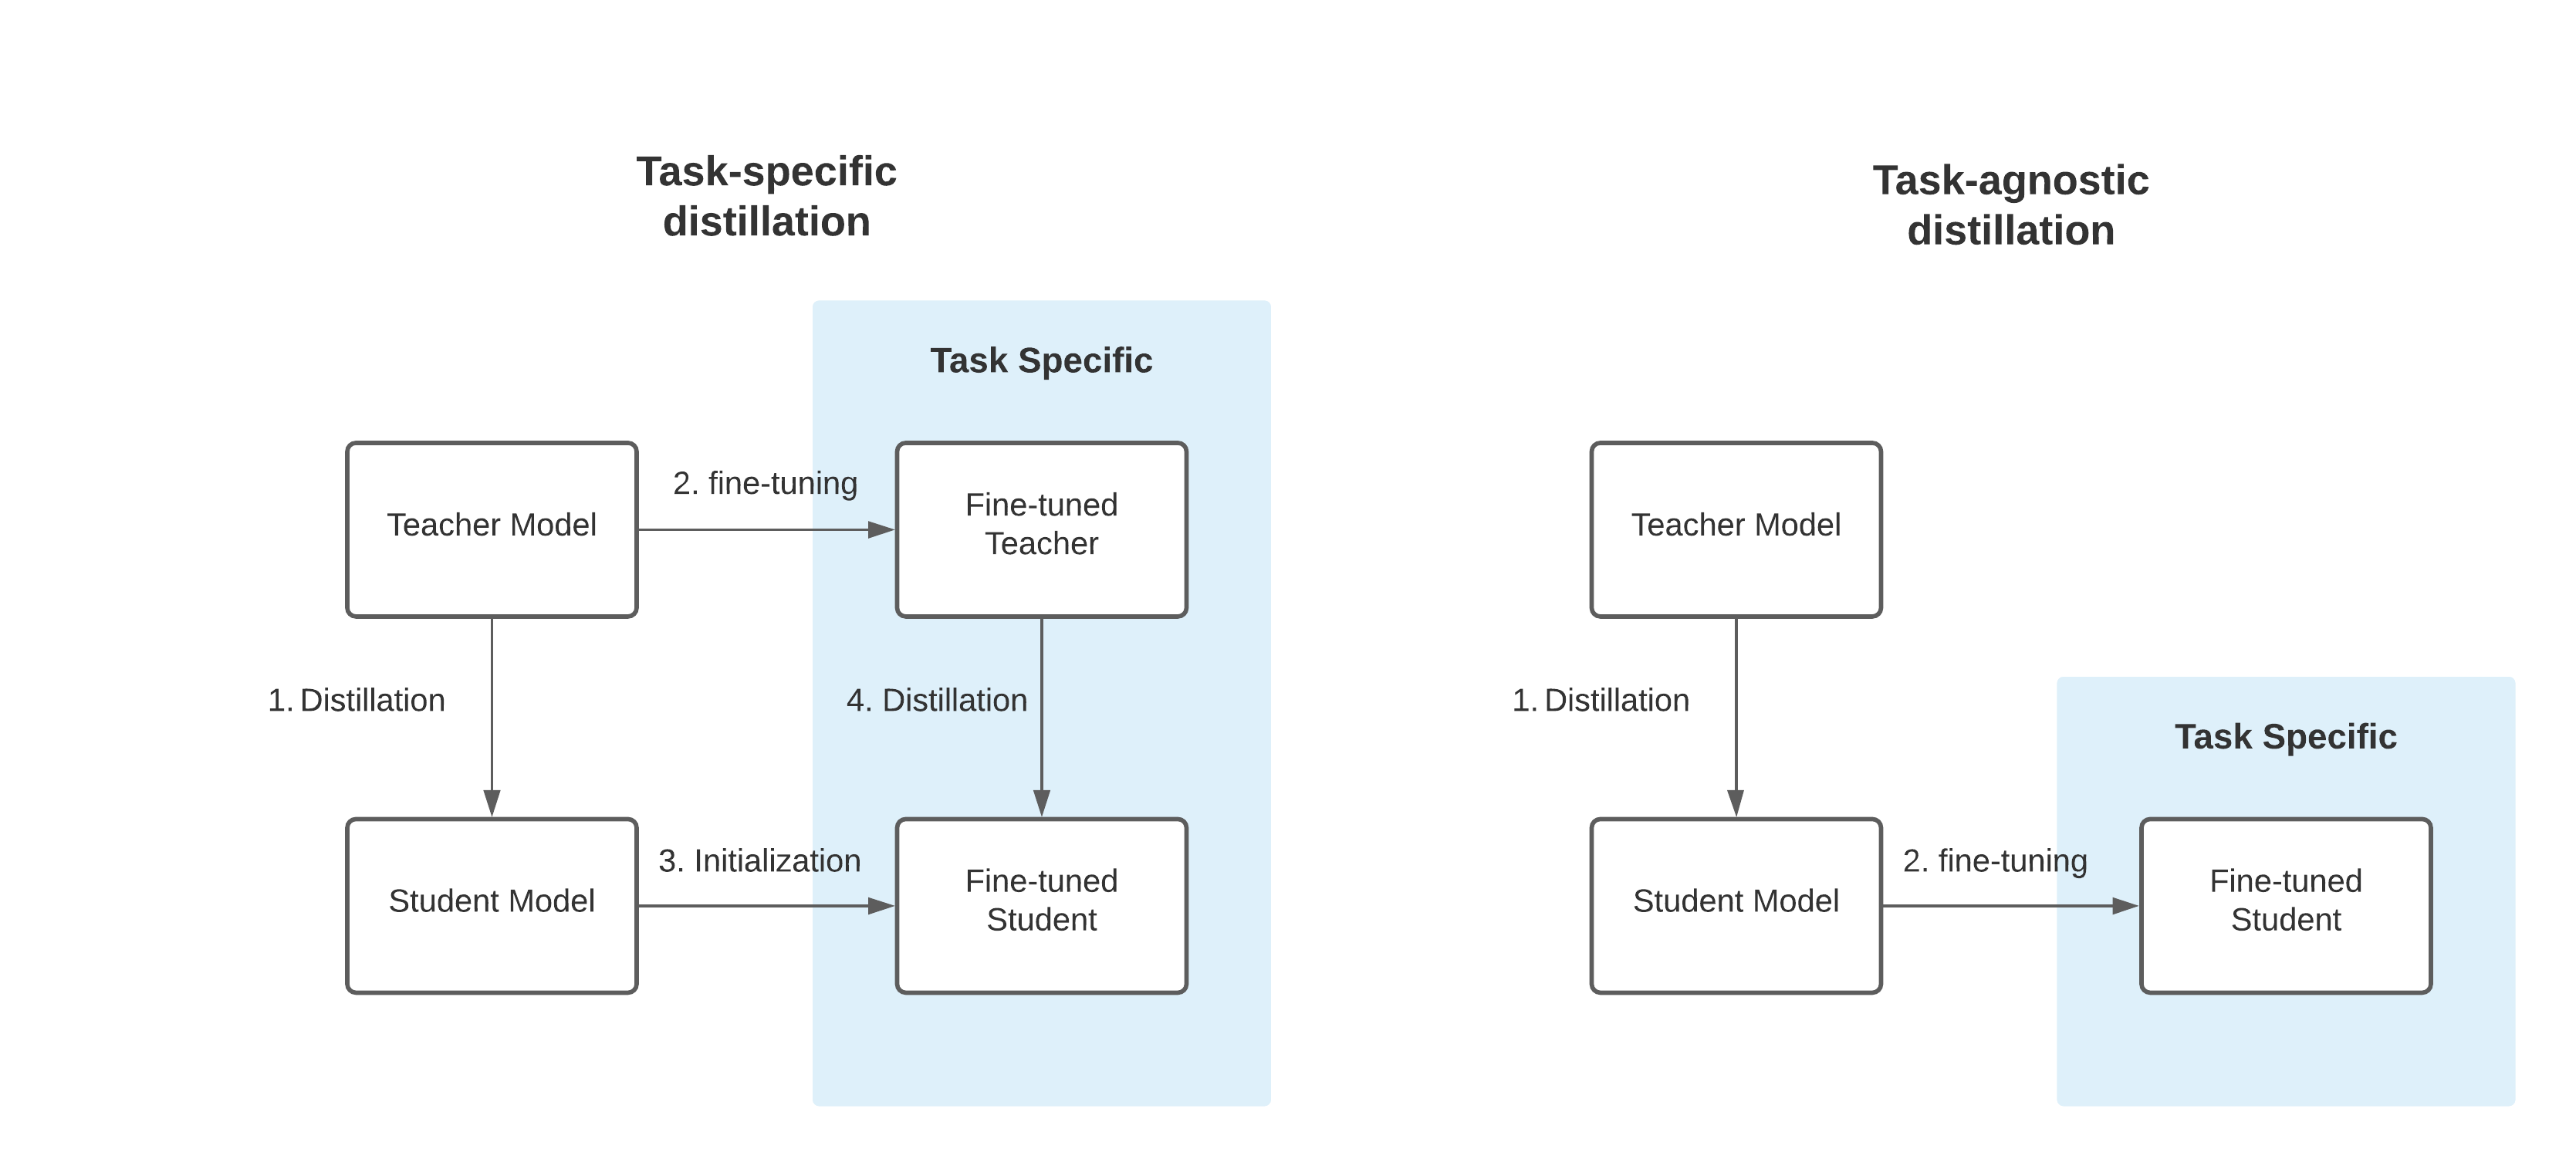

### Online vs Offline vs Self-distillation

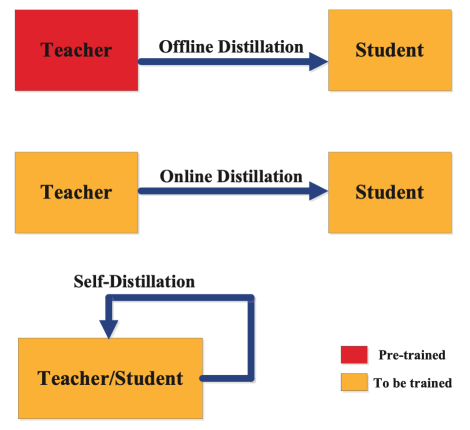

#### Online дистиляция

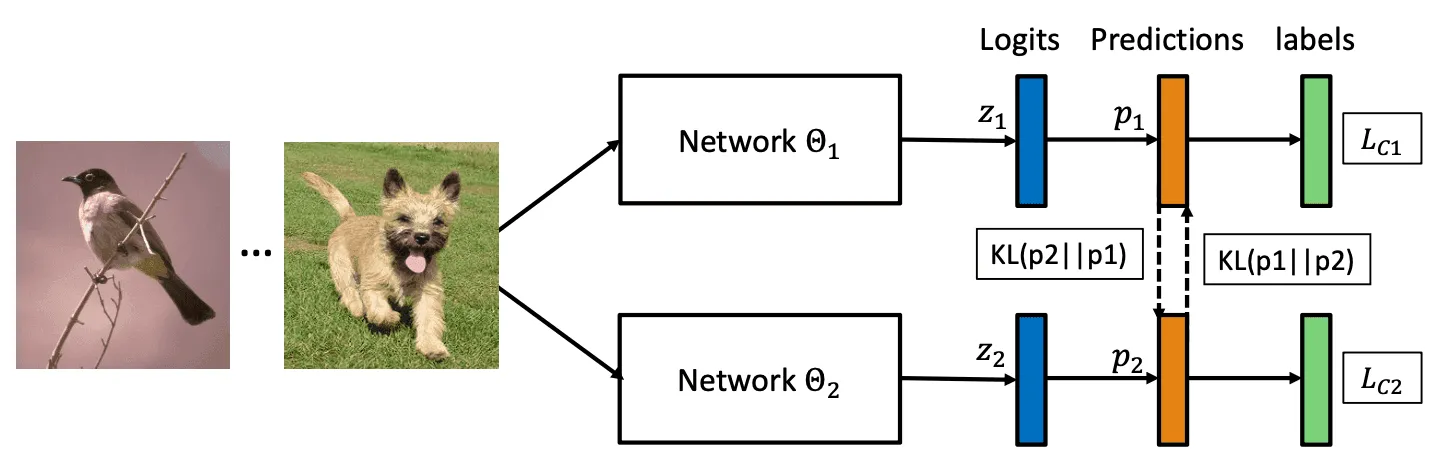


### Самодистилляция

В качестве отдельного режима дистилляции знаний принято выделять также самодистилляцию (self-distillation), при которой учитель и ученик являются одной и той же моделью. Самодистилляция включает в себя две основные группы методов.

- Первая группа методов направлена на использование информации, которая накапливается в модели во время обучения, для дополнительного улучшения качества предсказаний той же самой модели.

- Вторая группа методов по сути заключается в offline дистилляции из обученной модели в новую модель такой же архитектуры. То есть мы выбираем некоторую архитектуру нейронной сети, обучаем одну модель стандартным образом, а затем обучаем точно такую же модель из новой случайной инициализации с использованием хинтоновской дистилляции из ранее обученной модели.


In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers datasets tensorboard accelerate

### Набор данных

[SST-2](https://) - набор обзоров фильмов с IMDb с разбивкой на эмоциональный окрас — позитивный или негативный. Метрика - accuracy

[ BERT-base](https://huggingface.co/textattack/bert-base-uncased-SST-2) - Teacher, [BERT-Tiny](https://huggingface.co/google/bert_uncased_L-2_H-128_A-2/tree/main) - Student

In [ ]:
from huggingface_hub import notebook_login, create_repo, whoami

In [ ]:
notebook_login()

In [ ]:
whoami()

{'type': 'user',
 'id': '63c469c9a361002ba0bd08f0',
 'name': 'masterkristall',
 'fullname': 'Kristina',
 'email': 'masterkristall@gmail.com',
 'emailVerified': True,
 'plan': 'NO_PLAN',
 'canPay': False,
 'isPro': False,
 'periodEnd': None,
 'avatarUrl': '/avatars/cab77e2087243c970e17c975790f5453.svg',
 'orgs': [],
 'auth': {'type': 'access_token',
  'accessToken': {'displayName': 'stable_diffusion_tests', 'role': 'read'},
  'permissions': ['inference-api']}}

In [ ]:
repo_name = "bert_distillation_0"
create_repo(repo_name, private=False)

RepoUrl('https://huggingface.co/masterkristall/bert_distillation_0', endpoint='https://huggingface.co', repo_type='model', repo_id='masterkristall/bert_distillation_0')

In [ ]:
student_name = "google/bert_uncased_L-2_H-128_A-2"
teacher_name = "textattack/bert-base-uncased-SST-2"

In [ ]:
from transformers import AutoTokenizer

teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_name)
student_tokenizer = AutoTokenizer.from_pretrained(student_name)

sample = "This is a basic example, with different words to test."

# assert results
assert teacher_tokenizer(sample) == student_tokenizer(sample)

In [ ]:
dataset_id = "glue"
dataset_config = "sst2"

In [ ]:
from datasets import load_dataset

dataset = load_dataset(dataset_id, dataset_config)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [ ]:
def process(examples):
    tokenized_inputs = teacher_tokenizer(
        examples["sentence"], truncation=True, max_length=512
    )
    return tokenized_inputs

tokenized_datasets = dataset.map(process, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets["test"].features

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

{'sentence': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

[Knowledge Distillation - loss](https://intellabs.github.io/distiller/knowledge_distillation.html)

In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)

        self.alpha = alpha
        self.temperature = temperature

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        # place teacher on same device as student
        self._move_model_to_device(self.teacher, self.model.device)
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        # compute student output
        outputs_student = model(**inputs)
        student_loss = outputs_student.loss
        # compute teacher output
        with torch.no_grad():
          outputs_teacher = self.teacher(**inputs)

        # assert size
        assert outputs_student.logits.size() == outputs_teacher.logits.size()

        # Soften probabilities and compute distillation loss
        loss_function = nn.KLDivLoss(reduction="batchmean")
        loss_logits = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))
        # Return weighted student loss
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits
        return (loss, outputs_student) if return_outputs else loss

In [ ]:
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from huggingface_hub import HfFolder

# create label2id, id2label dicts for nice outputs for the model
labels = tokenized_datasets["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# define training args
training_args = DistillationTrainingArguments(
    output_dir=repo_name,
    num_train_epochs=7,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    fp16=True,
    learning_rate=1e-4,
    seed=2023,
    # logging & evaluation strategies
    logging_dir=f"{repo_name}/logs",
    logging_strategy="epoch", # to get more information to TB
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="tensorboard",
    # push to hub parameters
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repo_name,
    hub_token=HfFolder.get_token(),
    # distilation parameters
    alpha=0.5,
    temperature=4.0
)

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=teacher_tokenizer)

# define model
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# define student model
student_model = AutoModelForSequenceClassification.from_pretrained(
    student_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import load_metric
import numpy as np

# define metrics and metrics function
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {
        "accuracy": acc["accuracy"],
    }

<ipython-input-12-377ef03150f0>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric( "accuracy")


In [ ]:
trainer = DistillationTrainer(
    student_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=teacher_tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 2.1649012565612793,
 'eval_accuracy': 0.4908256880733945,
 'eval_runtime': 5.4549,
 'eval_samples_per_second': 159.857,
 'eval_steps_per_second': 1.283}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.269700,1.044469,0.819954
2,0.678400,1.016836,0.817661
3,0.520600,1.135592,0.810780
4,0.438300,1.143677,0.827982
5,0.384400,1.168672,0.826835
6,0.354700,1.178440,0.830275
7,0.337300,1.204520,0.827982


TrainOutput(global_step=3689, training_loss=0.5690449161172786, metrics={'train_runtime': 1441.582, 'train_samples_per_second': 327.032, 'train_steps_per_second': 2.559, 'total_flos': 56531524333500.0, 'train_loss': 0.5690449161172786, 'epoch': 7.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.1784404516220093,
 'eval_accuracy': 0.8302752293577982,
 'eval_runtime': 2.7864,
 'eval_samples_per_second': 312.95,
 'eval_steps_per_second': 2.512,
 'epoch': 7.0}

In [ ]:
trainer.create_model_card(model_name=training_args.hub_model_id)
trainer.push_to_hub()

events.out.tfevents.1701202093.62074d9d7b32.1179.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

events.out.tfevents.1701200631.62074d9d7b32.1179.0:   0%|          | 0.00/8.28k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/masterkristall/bert_distillation_0/tree/main/'

### Pure tiny-bert

In [ ]:
student_model = AutoModelForSequenceClassification.from_pretrained(
    student_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
repo_name_tiny = "bert_distillation_tiny"
create_repo(repo_name_tiny, private=False)

RepoUrl('https://huggingface.co/masterkristall/bert_distillation_tiny', endpoint='https://huggingface.co', repo_type='model', repo_id='masterkristall/bert_distillation_tiny')

In [ ]:
training_args = TrainingArguments(
    output_dir=repo_name_tiny,
    num_train_epochs=7,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    fp16=True,
    learning_rate=1e-4,
    seed=2023,
    # logging & evaluation strategies
    logging_dir=f"{repo_name_tiny}/logs",
    logging_strategy="epoch", # to get more information to TB
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="tensorboard",
    # push to hub parameters
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repo_name_tiny,
    hub_token=HfFolder.get_token(),
)

In [ ]:
trainer = Trainer(
    student_model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=student_tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6884961724281311,
 'eval_accuracy': 0.5172018348623854,
 'eval_runtime': 0.1369,
 'eval_samples_per_second': 6371.646,
 'eval_steps_per_second': 51.149}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.413900,0.420404,0.809633
2,0.270000,0.427403,0.825688
3,0.222600,0.489933,0.824541
4,0.193100,0.496123,0.822248
5,0.173200,0.530243,0.822248
6,0.160800,0.539278,0.823394
7,0.152000,0.556166,0.817661


TrainOutput(global_step=3689, training_loss=0.22652187125086298, metrics={'train_runtime': 102.64, 'train_samples_per_second': 4593.171, 'train_steps_per_second': 35.941, 'total_flos': 56531524333500.0, 'train_loss': 0.22652187125086298, 'epoch': 7.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.427403062582016,
 'eval_accuracy': 0.8256880733944955,
 'eval_runtime': 0.14,
 'eval_samples_per_second': 6230.179,
 'eval_steps_per_second': 50.013,
 'epoch': 7.0}

In [ ]:
trainer.create_model_card(model_name=training_args.hub_model_id)
trainer.push_to_hub()

events.out.tfevents.1701202155.62074d9d7b32.1179.2:   0%|          | 0.00/8.29k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1701202309.62074d9d7b32.1179.3:   0%|          | 0.00/411 [00:00<?, ?B/s]

'https://huggingface.co/masterkristall/bert_distillation_tiny/tree/main/'

[Маленький и быстрый BERT для русского языка](https://habr.com/ru/articles/562064/)